In [1]:
import numpy as np
from itertools import product
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [2]:
def generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size):
    r = (wheel_pixel_size / 2) - 1
    theta = np.arange(n_hooks, dtype="float64") / n_hooks * (2 * np.pi)
    epsilon = np.arcsin(hook_pixel_size / wheel_pixel_size)

    theta_acw = theta.copy() + epsilon
    theta_cw = theta.copy() - epsilon
    
    theta = np.stack((theta_cw, theta_acw)).ravel("F")
    
    x = r * (1 + np.cos(theta)) + 0.5
    y = r * (1 + np.sin(theta)) + 0.5
    
    return np.array((x,y)).T


def through_pixels(p0, p1):
    
    d = max(int(((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2) ** 0.5), 1)
    
    pixels = p0 + (p1-p0) * np.array([np.arange(d+1), np.arange(d+1)]).T / d
    pixels = np.unique(np.round(pixels), axis=0).astype(int)
    
    return pixels


def build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size):

    n_hook_sides = n_hooks * 2

    l = [(0,1)]
    for j in range(n_hook_sides):
        for i in range(j):
            if j-i > 10 and j-i < (n_hook_sides - 10):
                l.append((i, j))
                
    
    random_order = np.random.choice(len(l),len(l),replace=False)
    
    d = {}    
    t_list = []
    t0 = time.time()
    
    for n in range(len(l)):
        (i, j) = l[random_order[n]]
        p0, p1 = hooks[i], hooks[j]
        d[(i,j)] = through_pixels(p0, p1)
        
        t = time.time() - t0
        t_left = t * (len(l) - n - 1) / (n + 1)
        print(f"time left = {time.strftime('%M:%S', time.gmtime(t_left))}", end="\r")
    
    clear_output()
    return d

In [3]:
def fitness(image, line, darkness, lp, w, w_pos, w_neg, line_norm_mode):
    
    pixels = through_pixels_dict[tuple(sorted(line))]
    
    old_pixel_values = image[tuple(pixels.T)]
    new_pixel_values = old_pixel_values - darkness

    if type(w) == bool and type(w_pos) == bool:
        new_penalty = new_pixel_values.sum() - (1 + lp) * new_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_pixel_values.sum() - (1 + lp) * old_pixel_values[old_pixel_values < 0].sum()
    elif type(w_pos) == bool:
        pixel_weightings = w[tuple(pixels.T)]
        new_w_pixel_values = new_pixel_values * pixel_weightings
        old_w_pixel_values = old_pixel_values * pixel_weightings
        new_penalty = new_w_pixel_values.sum() - (1 + lp) * new_w_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_w_pixel_values.sum() - (1 + lp) * old_w_pixel_values[old_pixel_values < 0].sum()
    elif type(w) == bool:
        pos_pixel_weightings = w_pos[tuple(pixels.T)]
        neg_pixel_weightings = w_neg[tuple(pixels.T)]
        new_wpos_pixel_values = new_pixel_values * pos_pixel_weightings
        new_wneg_pixel_values = new_pixel_values * neg_pixel_weightings
        old_wpos_pixel_values = old_pixel_values * pos_pixel_weightings
        old_wneg_pixel_values = old_pixel_values * neg_pixel_weightings
        new_penalty = new_wpos_pixel_values[new_pixel_values > 0].sum() - lp * new_wneg_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_wpos_pixel_values[old_pixel_values > 0].sum() - lp * old_wneg_pixel_values[old_pixel_values < 0].sum()

    if line_norm_mode == "length":
        line_norm = len(pixels)
    elif line_norm_mode == "weighted length":
        if type(w_pos) == bool:
            line_norm = pixel_weightings.sum()
        else:
            line_norm = pos_pixel_weightings.sum()
    elif line_norm_mode == "none":
        line_norm = 1
        
    if line_norm == 0:
        return 0
    else:
        return (old_penalty - new_penalty) / line_norm


def optimise_fitness(image, previous_edge, darkness, lightness_penalty, list_of_lines, 
                     w, w_pos, w_neg, line_norm_mode, time_saver):
    
    if previous_edge % 2 == 0:
        starting_edge = previous_edge + 1
    else:
        starting_edge = previous_edge - 1
          
    sides_A = np.ones(n_hooks * 2) * starting_edge
    sides_B = np.arange(n_hooks * 2)
    next_lines = np.stack((sides_A, sides_B)).ravel("F").reshape((n_hooks * 2, 2)).astype(int)
    mask = (np.abs(next_lines.T[1] - next_lines.T[0]) > 10) & (np.abs(next_lines.T[1] - next_lines.T[0]) < n_hooks * 2 - 10)
    next_lines = next_lines[mask]
    
    if time_saver == 1:
        next_lines = next_lines.tolist()
    else:
        next_lines = next_lines[np.random.choice(np.arange(len(next_lines)), int(len(next_lines) * time_saver))].tolist()

    fitness_list = [fitness(image, line, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode) for line in next_lines]
    best_line_idx = fitness_list.index(max(fitness_list))
    best_line = next_lines[best_line_idx]

    pixels = through_pixels_dict[tuple(sorted(best_line))]
    image[tuple(pixels.T)] -= darkness
    
    return image, best_line

In [4]:
def find_lines(image, n_lines, darkness, lightness_penalty, line_norm_mode, w=False, w_pos=False, w_neg=False, time_saver=1):
    
    list_of_lines = []
    previous_edge = np.random.choice(n_hooks * 2)
    
    image_copy = image.copy()
    
    for i in range(n_lines):
        
        if i == 0:
            t0 = time.time()
            initial_penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
            initial_avg_penalty = f'{initial_penalty / (wheel_pixel_size ** 2):.2f}'
        elif i%100 == 0:
            t_so_far = time.strftime('%M:%S', time.gmtime(time.time() - t0))
            t_left = time.strftime('%M:%S', time.gmtime((time.time() - t0) * (n_lines - i) / i))   
            penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
            print(f"{i}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}, \
time = {t_so_far}, time left = {t_left}    ", end="\r")                
        
        image, line = optimise_fitness(image_copy, previous_edge, darkness, lightness_penalty, list_of_lines, 
                                       w, w_pos, w_neg, line_norm_mode, time_saver)
        previous_edge = line[1]
        
        list_of_lines.append(line)

    
    clear_output()
    
    penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
    avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
    print(f"{len(list_of_lines)}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}")
    print("time = " + time.strftime('%M:%S', time.gmtime(time.time() - t0)))
    
    return list_of_lines
        

def get_penalty(image, lightness_penalty, w, w_pos, w_neg):
    
    if type(w) == bool and type(w_pos) == bool:
        return image.sum() - (1 + lightness_penalty) * image[image<0].sum()
    elif type(w_pos) == bool:
        image_w = image * w
        return image_w.sum() - (1 + lightness_penalty) * image_w[image<0].sum()
    elif type(w) == bool:
        image_wpos = image * w_pos
        image_wneg = image * w_neg
        return image_wpos[image>0].sum() - lightness_penalty * image_wneg[image<0].sum() 

In [5]:
def prepare_image(file_name, colour=False, weighting=False):
    image = Image.open(file_name).resize((wheel_pixel_size, wheel_pixel_size))
    
    if colour:
        image = np.array(image.convert(mode="HSV").getdata()).reshape((wheel_pixel_size, wheel_pixel_size,3))[:,:,1]
    elif weighting:     
        image = 1 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size)) / 255
    else:
        image = 255 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size))
    
    coords = np.array(list(product(range(wheel_pixel_size), range(wheel_pixel_size))))
    x_coords = coords.T[0]
    y_coords = coords.T[1]
    coords_distance_from_centre = np.sqrt((x_coords - (wheel_pixel_size-1)*0.5)**2 + (y_coords - (wheel_pixel_size-1)*0.5)**2)
    mask = np.array(coords_distance_from_centre > wheel_pixel_size*0.5)
    mask = np.reshape(mask, (-1, wheel_pixel_size))
    image[mask] = 0                             
    
    return image.T[:,::-1]


def display_images(image_list):
    
    fig, axs = plt.subplots(1,len(image_list),figsize=(30,30));
    for (i,j) in zip(range(len(image_list)), image_list):
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].imshow(j[:,::-1].T, cmap=plt.get_cmap("Greys"));

In [6]:
def save_plot(list_coloured_lines, list_colours, file_name, size):
        
    new_hooks = generate_hooks(n_hooks, size, hook_pixel_size)
    
    for i in range(len(new_hooks)):
        new_hooks[i] = [new_hooks[i][0], size - new_hooks[i][1]]
    
    thread_image = Image.new('RGB', (size,size), (255,255,255))
    draw = ImageDraw.Draw(thread_image)
    
    for (lines, colour) in zip(list_coloured_lines, list_colours):
        pixel_pairs = [(new_hooks[n[0]], new_hooks[n[1]]) for n in lines]
        for j in pixel_pairs:
            draw.line((tuple(j[0]), tuple(j[1])), fill=colour)
        
    thread_image.save(file_name + ".jpg", format="JPEG")
    
    
def save_plot_progress(list_coloured_lines, list_colours, file_name, size, proportion_list):
    
    for prop in proportion_list:
        file_name_temp = f"{file_name} {int(100*prop)}%"
        lines_temp = list_coloured_lines[-1][:int(len(list_coloured_lines[-1])*prop)]
        list_coloured_lines_temp = list_coloured_lines[:-1] + [lines_temp]
        save_plot(list_coloured_lines_temp, list_colours, file_name_temp, size=size)

In [7]:
def total_distance(lines):
    
    d = 0
    for line in lines:
        hook_A, hook_B = hooks[line[0]], hooks[line[1]]
        d += ((hook_A[0]-hook_B[0])**2 + (hook_A[1]-hook_B[1])**2) ** 0.5 + hook_pixel_size
    
    d = d * (wheel_real_size / wheel_pixel_size)
    
    print(f"distance = {int(d)} meters")   

    
def display_output(lines):
    print(f"{lines[0][0]//2}-{lines[0][0]%2}")
    for i in range(len(lines)):
        if i%100 == 0 and i>0:
            print(f"\n{i}\n")
        line = lines[i]
        output_number = f"{line[1]//2}-{line[1]%2}"
        print(output_number)

In [ ]:
wheel_real_size = 0.58
hook_real_size = 6 * (10**-3)
wheel_pixel_size = 3000
hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size 
n_hooks = 180

hooks = generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size)
through_pixels_dict = build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size)

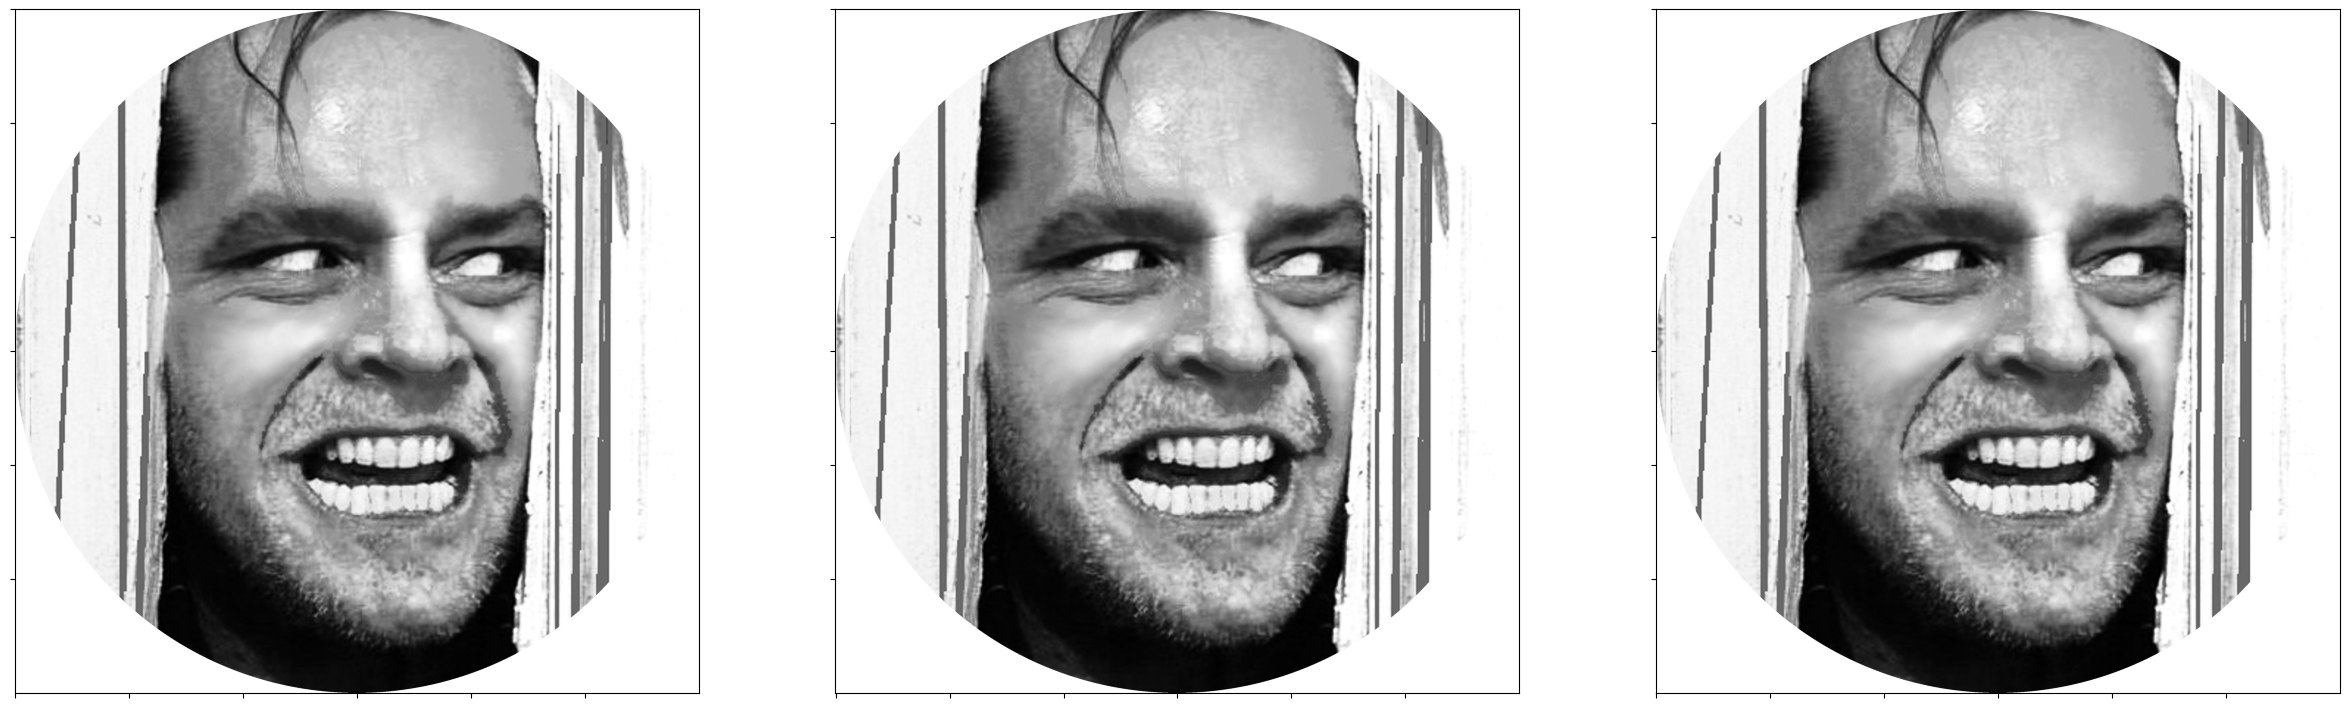

In [9]:
image_m = prepare_image('jack_nicholson_monochrome.jpg')
image_w = prepare_image('jack_nicholson_monochrome.jpg', weighting=True)
image_list = [image_m, image_m, image_w]
display_images(image_list)

In [10]:
lines = find_lines(image_m, n_lines=3000, 
                   darkness=180, lightness_penalty=0.35, 
                   w=image_w, line_norm_mode="weighted length",
                   time_saver=0.5)

3000/3000, average penalty = 29.66/58.07
time = 01:33


In [23]:
save_plot_progress([lines], [(0,0,0)], "gautham output", 3000, [0.2, 0.4, 0.6, 0.8, 1])

In [32]:
total_distance(lines)

distance = 1330 meters


In [33]:
display_output(lines)

88-1
47-0
42-0
51-0
41-0
49-1
43-1
50-1
43-1
56-0
63-1
57-1
63-1
122-0
142-0
148-0
140-1
126-0
133-1
127-0
149-1
133-1
118-0
148-0
116-1
144-0
122-0
144-0
120-0
149-1
116-0
136-1
124-0
134-1
141-0
123-0
139-0
123-0
147-1
119-0
145-0
115-0
150-1
119-1
145-0
117-1
147-1
121-0
143-0
133-1
144-0
132-0
75-0
135-0
117-1
148-0
114-0
150-1
116-1
139-0
120-0
143-1
134-1
126-0
148-1
115-0
150-0
114-0
153-0
114-0
148-1
118-0
145-1
129-1
147-0
118-1
59-0
119-0
61-0
115-0
145-0
121-1
61-0
119-1
62-0
123-0
136-1
142-0
122-0
148-1
128-0
147-1
117-0
149-1
113-0
150-1
116-0
148-0
116-0
143-0
123-0

100

141-0
125-1
62-0
122-1
149-0
111-1
147-1
120-0
59-1
121-1
149-1
112-0
152-0
115-1
153-0
113-0
67-0
114-0
62-0
123-1
137-1
79-1
137-0
81-1
8-1
81-0
137-0
81-0
11-1
80-0
10-0
80-1
11-1
80-1
137-0
129-0
146-1
117-0
60-0
119-1
142-1
119-1
145-1
131-1
145-1
125-0
61-1
124-0
62-1
115-1
152-1
57-0
42-1
36-1
29-0
40-0
52-1
63-0
157-1
63-0
55-0
118-0
58-1
119-0
147-1
121-1
138-0
126-1
149-0
116-0
62-1
118-1
59-1